In [1]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

from typing import Tuple, Dict, Optional

import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from jaxley_mech.channels.lk04 import h, Kx, Kv, Ca, CaPump, CaNernstReversal, KCa, ClCa, Leak

import jaxley as jx
from jaxley import Compartment


In [2]:
class Compartment(Compartment):
    """
    Extend the Compartment class to include a voltage clamp method.
    """

    def voltage_clamp(
        self, V_hold1: float, V_step: float, T_hold1: int, T_step: int, dt: float,
        V_hold2: Optional[float] = None, T_hold2: Optional[int] = None,
        init_params = None
    ) -> Tuple[
        Dict[str, jnp.ndarray], Dict[str, Dict[str, jnp.ndarray]]
    ]:
        """
        Apply a voltage clamp to the Compartment and record the resulting currents and state changes.

        Args:
            V_hold1: The first holding voltage in mV.
            V_step: The step voltage in mV.
            T_hold1: The duration of the first holding voltage in time steps.
            T_step: The duration of the step voltage in time steps.
            dt: The time step in ms.
            V_hold2: The second holding voltage in mV (optional, defaults to V_hold1).
            T_hold2: The duration of the second holding voltage in time steps (optional, defaults to T_hold1).

        Returns:
            A tuple containing a dictionary for the currents and a dictionary for the state histories.
        """
        if V_hold2 is None:
            V_hold2 = V_hold1
        if T_hold2 is None:
            T_hold2 = T_hold1

        # Initialize the global state and dictionaries for currents and states
        params = {}
        states = {}
        channel_currents = {
            "hold1": {channel._name: [] for channel in self.channels},
            "step": {channel._name: [] for channel in self.channels},
            "hold2": {channel._name: [] for channel in self.channels},
        }
        channel_states_history = {
            "hold1": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },
            "step": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },
            "hold2": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },
        }

        for channel in self.channels:
            states.update(channel.channel_states)
            params.update(channel.channel_params)

        if init_params is not None:
            params.update(init_params)
        
        # self.to_jax()

        def update_all_channels(V, dt, phase, states):
            for channel in self.channels:
                # Compute and store the current for the channel
                current = channel.compute_current(states, V, params)
                states[f"i{channel._name}"] = current
                channel_currents[phase][channel._name].append(current)

                # Update the states
                new_states = channel.update_states(states, dt, V, params)
                states.update(new_states)
                for state_key, state_value in new_states.items():
                    channel_states_history[phase][channel._name][state_key].append(state_value)

            return states

        # First hold phase
        for _ in range(T_hold1):
            states = update_all_channels(V_hold1, dt, "hold1", states)

        # Step phase
        for _ in range(T_step):
            states = update_all_channels(V_step, dt, "step", states)

        # Second hold phase
        for _ in range(T_hold2):
            states = update_all_channels(V_hold2, dt, "hold2", states)

        # Convert lists to jnp.ndarray and merge all phases
        merged_currents = {}
        for channel_name in channel_currents["hold1"]:
            merged_currents[channel_name] = jnp.concatenate([
                jnp.array(channel_currents["hold1"][channel_name]),
                jnp.array(channel_currents["step"][channel_name]),
                jnp.array(channel_currents["hold2"][channel_name])
            ])

        merged_states_history = {}
        for channel_name in channel_states_history["hold1"]:
            merged_states_history[channel_name] = {}
            for state_name in channel_states_history["hold1"][channel_name]:
                merged_states_history[channel_name][state_name] = jnp.concatenate([
                    jnp.array(channel_states_history["hold1"][channel_name][state_name]),
                    jnp.array(channel_states_history["step"][channel_name][state_name]),
                    jnp.array(channel_states_history["hold2"][channel_name][state_name])
                ])

        return merged_currents, merged_states_history


### Kx Channel

Figure 3 from Kourennyi, D. E., Liu, X., & Barnes, S. (2002). Modulation of Rod Photoreceptor Potassium Kx Current by Divalent Cations. Annals of Biomedical Engineering, 30(9), 1196–1203. https://doi.org/10.1114/1.1521415


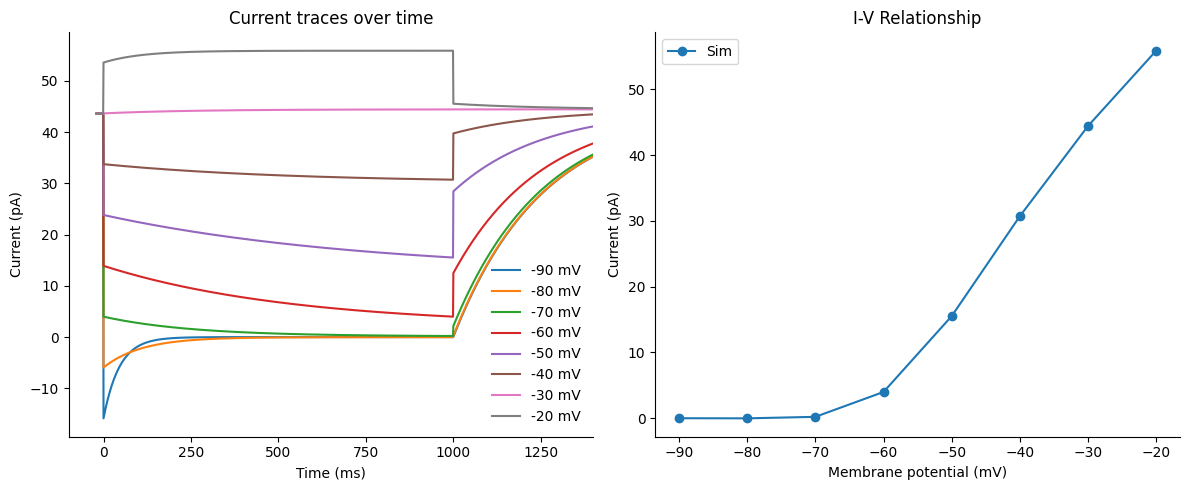

In [3]:
# Parameters for voltage clamp
V_hold = -30  # mV
V_steps = jnp.arange(-90, -10, 10)  # Step voltages from -53 mV to -113 mV in -10 mV increments
T_hold = 1000  # 1000 ms = 1 second
T_step = 1000  # 1000 ms = 1 second
dt = 1  # ms

# Create the compartment and add the h channel
compartment = Compartment()
compartment.insert(Kx())


# Lists to store results
all_currents = []
steady_state_currents = []

# Run voltage clamp for each step voltage
for V_step in V_steps:
    currents, _ = compartment.voltage_clamp(V_hold1=V_hold, V_step=V_step, T_hold1=T_hold, T_step=T_step, dt=dt)
    current_trace = currents["Kx"]
    all_currents.append(current_trace)

    # Extract the steady-state current at the end of the step phase
    steady_state_current = current_trace[T_hold + T_step - 1]  # Last current value during the step
    steady_state_currents.append(steady_state_current)

# Convert results to numpy arrays for plotting
all_currents = jnp.array(all_currents)
steady_state_currents = jnp.array(steady_state_currents)


######################
## Figure 2 A and B ##
######################

# Calculate indices for -20 ms before step and 100 ms after step
pre_step_duration = 20  # ms
post_step_duration = 400  # ms

pre_step_indices = pre_step_duration // dt
post_step_indices = post_step_duration // dt

# Indices for the step period in the merged array
start_step_index = T_hold - pre_step_indices
end_step_index = T_hold + T_step + post_step_indices

# Create the time axis
time_window = jnp.arange(-pre_step_duration, T_step + post_step_duration, dt)


fig, ax = plt.subplot_mosaic([["A", "B"]], figsize=(12, 5))

for i, V_step in enumerate(V_steps):
    ax["A"].plot(time_window, all_currents[i][start_step_index:end_step_index], label=f'{V_step} mV')
ax["A"].set_xlabel("Time (ms)")
ax["A"].set_ylabel("Current (pA)")
ax["A"].set_title("Current traces over time")
ax["A"].set_xlim(-100, 1400)
ax["A"].set_xticks(jnp.arange(0, 1500, 250))
ax["A"].legend(frameon=False)


# Plot panel B: I-V relationship
ax["B"].plot(V_steps, steady_state_currents, 'o-', label='Sim')
ax["B"].set_xlabel("Membrane potential (mV)")
ax["B"].set_ylabel("Current (pA)")
ax["B"].set_title("I-V Relationship")
ax["B"].legend()

for ax in ax.values():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()

### hyperpolarization-activated h channel

Figure 1 from Malcolm, A. T., Kourennyi, D. E., & Barnes, S. (2003). Protons and calcium alter gating of the hyperpolarization-activated cation current (Ih) in rod photoreceptors. Biochimica et Biophysica Acta (BBA) - Biomembranes, 1609(2), 183–192. https://doi.org/10.1016/S0005-2736(02)00687-9


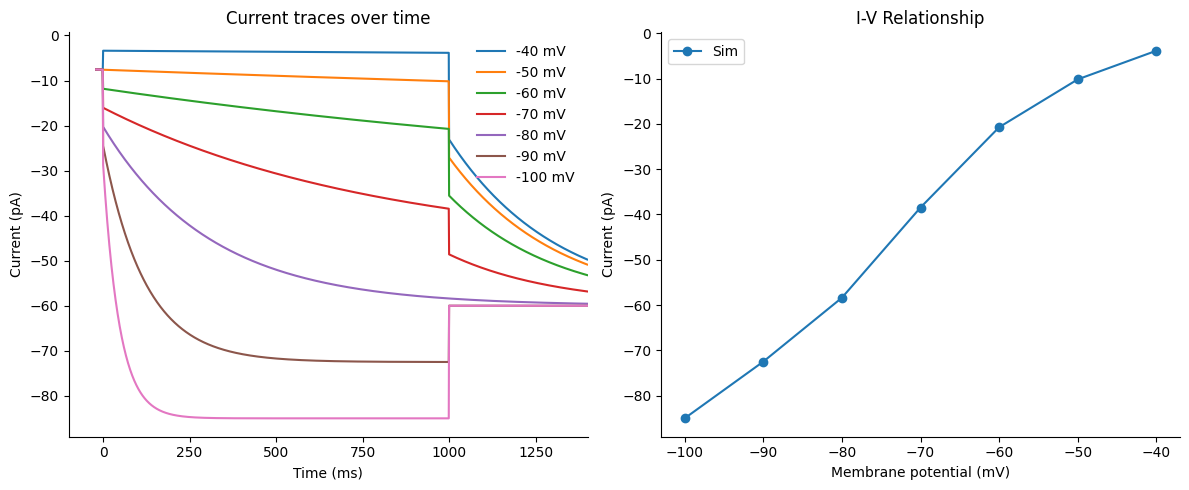

In [4]:
# Parameters for voltage clamp
V_hold = -50  # mV
V_hold2 = -80
V_steps = jnp.arange(-40, -110, -10)  # Step voltages from -53 mV to -113 mV in -10 mV increments
T_hold = 1000  # 1000 ms = 1 second
T_step = 1000  # 1000 ms = 1 second
dt = 1  # ms

# Create the compartment and add the h channel
compartment = Compartment()
compartment.insert(h())

# Lists to store results
all_currents = []
steady_state_currents = []

# Run voltage clamp for each step voltage
for V_step in V_steps:
    currents, _ = compartment.voltage_clamp(V_hold1=V_hold, T_hold1=T_hold, 
                                            V_step=V_step,  T_step=T_step, 
                                            V_hold2=V_hold2, dt=dt)
    current_trace = currents["h"]
    all_currents.append(current_trace)

    # Extract the steady-state current at the end of the step phase
    steady_state_current = current_trace[T_hold + T_step - 1]  # Last current value during the step
    steady_state_currents.append(steady_state_current)

# Convert results to numpy arrays for plotting
all_currents = jnp.array(all_currents)
steady_state_currents = jnp.array(steady_state_currents)

##############
## Figure 1 ##
##############

# Calculate indices for -20 ms before step and 100 ms after step
pre_step_duration = 20  # ms
post_step_duration = 400  # ms

pre_step_indices = pre_step_duration // dt
post_step_indices = post_step_duration // dt

# Indices for the step period in the merged array
start_step_index = T_hold - pre_step_indices
end_step_index = T_hold + T_step + post_step_indices

# Create the time axis
time_window = jnp.arange(-pre_step_duration, T_step + post_step_duration, dt)


fig, ax = plt.subplot_mosaic([["A", "B"]], figsize=(12, 5))

for i, V_step in enumerate(V_steps):
    ax["A"].plot(time_window, all_currents[i][start_step_index:end_step_index], label=f'{V_step} mV')
ax["A"].set_xlabel("Time (ms)")
ax["A"].set_ylabel("Current (pA)")
ax["A"].set_title("Current traces over time")
ax["A"].set_xlim(-100, 1400)
ax["A"].set_xticks(jnp.arange(0, 1500, 250))
ax["A"].legend(frameon=False)


# Plot panel B: I-V relationship
ax["B"].plot(V_steps, steady_state_currents, 'o-', label='Sim')
ax["B"].set_xlabel("Membrane potential (mV)")
ax["B"].set_ylabel("Current (pA)")
ax["B"].set_title("I-V Relationship")
ax["B"].legend()

for ax in ax.values():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()

### Kv channel

No reference given. No figure to compare with.

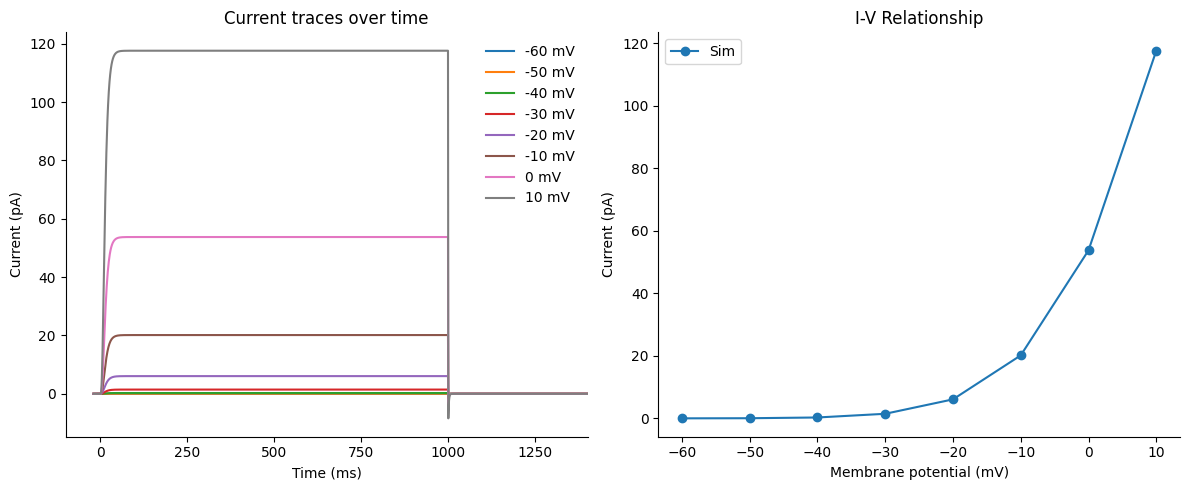

In [5]:
# Parameters for voltage clamp
V_hold = -80  # mV
V_steps = jnp.arange(-60, 20, 10)  # Step voltages from -53 mV to -113 mV in -10 mV increments
T_hold = 1000  # 1000 ms = 1 second
T_step = 1000  # 1000 ms = 1 second
dt = 1  # ms

# Create the compartment and add the h channel
compartment = Compartment()
compartment.insert(Kv())

# Lists to store results
all_currents = []
steady_state_currents = []

# Run voltage clamp for each step voltage
for V_step in V_steps:
    currents, _ = compartment.voltage_clamp(V_hold1=V_hold, V_step=V_step, T_hold1=T_hold, T_step=T_step, dt=dt)
    current_trace = currents["Kv"]
    all_currents.append(current_trace)

    # Extract the steady-state current at the end of the step phase
    steady_state_current = current_trace[T_hold + T_step - 1]  # Last current value during the step
    steady_state_currents.append(steady_state_current)

# Convert results to numpy arrays for plotting
all_currents = jnp.array(all_currents)
steady_state_currents = jnp.array(steady_state_currents)


######################
## Figure 2 A and B ##
######################

# Calculate indices for -20 ms before step and 100 ms after step
pre_step_duration = 20  # ms
post_step_duration = 400  # ms

pre_step_indices = pre_step_duration // dt
post_step_indices = post_step_duration // dt

# Indices for the step period in the merged array
start_step_index = T_hold - pre_step_indices
end_step_index = T_hold + T_step + post_step_indices

# Create the time axis
time_window = jnp.arange(-pre_step_duration, T_step + post_step_duration, dt)


fig, ax = plt.subplot_mosaic([["A", "B"]], figsize=(12, 5))

for i, V_step in enumerate(V_steps):
    ax["A"].plot(time_window, all_currents[i][start_step_index:end_step_index], label=f'{V_step} mV')
ax["A"].set_xlabel("Time (ms)")
ax["A"].set_ylabel("Current (pA)")
ax["A"].set_title("Current traces over time")
ax["A"].set_xlim(-100, 1400)
ax["A"].set_xticks(jnp.arange(0, 1500, 250))
ax["A"].legend(frameon=False)


# Plot panel B: I-V relationship
ax["B"].plot(V_steps, steady_state_currents, 'o-', label='Sim')
ax["B"].set_xlabel("Membrane potential (mV)")
ax["B"].set_ylabel("Current (pA)")
ax["B"].set_title("I-V Relationship")
ax["B"].legend()

for ax in ax.values():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()

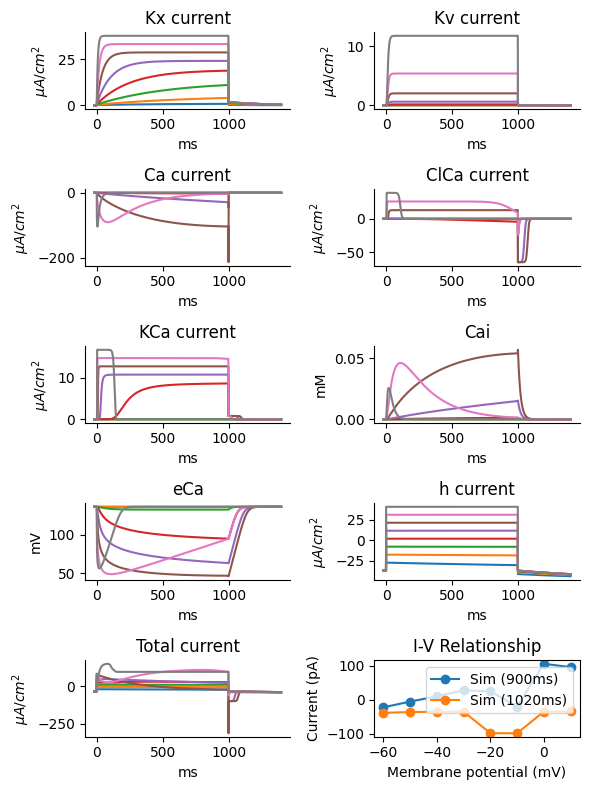

In [6]:
cell = Compartment()

cell.insert(Kx())
cell.insert(Kv())
cell.insert(Ca())
cell.insert(ClCa())
cell.insert(KCa())
cell.insert(CaPump())
cell.insert(CaNernstReversal())
cell.insert(h())
cell.insert(Leak())

params = {
    "CaPump_depth": 10,
    "CaPump_taur": 20, 
    "CaPump_cainf": 5e-5,    

    "Ca_gCa": 2e-3,
    "eCa": 40,
    
    "Kx_gKx": 0.45e-3,
    "Kv_gKv": 1e-3,
    "Ca_gCa": 4e-3,
    "ClCa_gClCa": 1.3e-3,
    "KCa_gKCa": 0.2e-3,


}

dt = 1 # ms    
V_hold = -70.0  # mV, the holding potential
T_hold = int(1000 / dt) # 300 ms
T_step = int(1000 / dt) # 300 ms


fig, ax = plt.subplots(5, 2, figsize=(6,8))
ax = ax.flatten()


# Calculate indices for -20 ms before step and 100 ms after step
pre_step_duration = 20  # ms
post_step_duration = 400  # ms

pre_step_indices = pre_step_duration // dt
post_step_indices = post_step_duration // dt

# Indices for the step period in the merged array
start_step_index = T_hold - pre_step_indices
end_step_index = T_hold + T_step + post_step_indices


# Create the time axis
time_window = jnp.arange(-pre_step_duration, T_step + post_step_duration, dt)

steady_state_currents_900 = []
steady_state_currents_1020 = []
V_steps = jnp.arange(-60, 20, 10)
for V_step in V_steps:
    currents, states = cell.voltage_clamp(V_hold1=V_hold, V_step=V_step, T_hold1=T_hold, T_step=T_step, dt=dt, init_params=params)
    ax = ax.flatten()
    for i, key in enumerate(currents):
        if key == "CaPump":
            ax[i].plot(time_window, states["CaPump"]["Cai"][start_step_index:end_step_index], label=f"V={V_step}")
            ax[i].set_title("Cai")
            ax[i].set_ylabel("mM")
        elif key == "CaNernstReversal":
            ax[i].plot(time_window, states["CaNernstReversal"]["eCa"][start_step_index:end_step_index], label=f"V={V_step}")
            ax[i].set_title("eCa")
            ax[i].set_ylabel("mV")
        else:
            if key == "Leak":
                continue
            ax[i].plot(time_window, currents[key][start_step_index:end_step_index], label=f"V={V_step}")
            ax[i].set_title(key + " current")
            ax[i].set_ylabel(r"$μA/cm^2$")

        ax[i].set_xlabel("ms")
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)

    total_current = jnp.vstack([currents[key] for key in ["Kv", "Ca", "ClCa", "KCa", "h", "Leak"]]).sum(0)
    
    ax[-2].plot(time_window, total_current[start_step_index:end_step_index], label=f"V={V_step}")
    ax[-2].set_title("Total current")
    ax[-2].set_ylabel(r"$μA/cm^2$")
    ax[-2].set_xlabel("ms")
    ax[-2].spines["top"].set_visible(False)
    ax[-2].spines["right"].set_visible(False)

    steady_state_currents_900.append(total_current[T_hold + 900])
    steady_state_currents_1020.append(total_current[T_hold + 1020])
    
ax[-1].plot(V_steps, steady_state_currents_900, 'o-', label='Sim (900ms)')
ax[-1].plot(V_steps, steady_state_currents_1020, 'o-', label='Sim (1020ms)')
ax[-1].set_xlabel("Membrane potential (mV)")
ax[-1].set_ylabel("Current (pA)")
ax[-1].set_title("I-V Relationship")
ax[-1].legend()

fig.tight_layout()

#################################
## Figure 3 + Figure 2 C and D ##
#################################

The iCa recovered too fast compared to the one reported in the paper, while the outflow of iClCa and iKCa are much weaker. The difference is likely due to different CaPump used. But the Torre et al. (1990) pump is very difficult to implement (also lack some paremeters to replicate it)... 

In [7]:
# Stimulus.
i_delay = 0.0  # ms
i_dur = 5000.0  # ms
i_offset = 0.0

# Duration and step size.
dt = 1  # ms
t_max = i_dur + 2 * i_delay  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

cell = Compartment()

cell.insert(Kx())   
cell.insert(Kv())
cell.insert(Ca())
cell.insert(ClCa())
cell.insert(KCa())
cell.insert(CaPump())
cell.insert(CaNernstReversal())
cell.insert(h())
cell.insert(Leak())

params = {
    "CaPump_depth": 10,
    "CaPump_Cai_tau": 200, 
    "CaPump_Cai_inf": 5e-5,


    "Ca_gCa": 4e-3,
    "eCa": 40,

    "ClCa_gClCa": 1.3e-3,
    "ClCa_eClCa": -20, 

    "KCa_gKCa": 0.2e-3,
    "KCa_Khalf": 0.332e-3,

    "Kx_gKx": 0.45e-3,
    "Kv_gKv": 1e-3,
    "eK": -74,

    "h_gh": 2.5e-3,
    "h_eh": -32,

    "v": -34,
}

# # for name, param in params.items():
# cell.set("length", 10)
# cell.set("radius", 10/2)

for name, param in params.items():
    print(name)
    cell.set(name, param)

def photocurrent(t, delay=20):
    t -= delay
    t1 = 32 * (1 - jnp.exp(-t / 0.05)) / 33
    t2 = -1 / (1 + jnp.exp(-(t - 3.8) / 0.45))
    t3 = (1 - jnp.exp(-t / 0.8)) / 33
    return -0.04 + 0.04 * jnp.maximum(t1 + t2 + t3, 0)

current = 0 * photocurrent(time_vec, delay=50)
# i_amp = 0.04
# offset= 0.00
# current = -jx.step_current(i_delay, i_dur, i_amp, dt, t_max, i_offset=i_offset)[:-1]

# current = 0 *photocurrent(time_vec, delay=2600)
cell.stimulate(current, verbose=False)

to_records = ["v", "Cai", "iCa", "ih", "iKx", "iKv", "iClCa", "iKCa"]
for rec in to_records:
    cell.record(rec, verbose=False)
# cell.record("v", verbose=False)



s = jx.integrate(cell, delta_t=dt)

fig, ax = plt.subplots(len(to_records)+1, 1, figsize=(12, 12))
ax = ax.flatten()
for j, rec in enumerate(to_records):
    
    ax[j].plot(time_vec[:2610], s[j].T[:2610], color=f"C{j}", label=rec)
    ax[j].set_title(rec)
    ax[j].spines["top"].set_visible(False)
    ax[j].spines["right"].set_visible(False)
ax[-1].plot(time_vec[:2610], current[:2610], color="black", label="I")

fig.tight_layout()

CaPump_depth
CaPump_Cai_tau


KeyError: 'Key not recognized.'

In [ ]:
# plt.plot(time_vec[2590:2610], s[1].T[2590:2610], color=f"C0")
